In [ ]:
"""

Date : August 1, 2019

Author : Heather Landry Drexler

This script will develop plots for Figure 2 of the nano-COP manuscript.

This script requires the files produced by the script nanoCOP_splice_df_datasets.ipynb
                                            

"""


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import re
% matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math

from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats, chi2_contingency
from scipy.special import stdtr

import pybedtools
from pybedtools import BedTool

import seaborn as sns
sns.set_style("white")



In [2]:
# FIGURE 2B - distance transcribed before splicing plot

# upload files from directory
K562_1_splice_df = pd.read_table("/path/to/K562_1_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_2_splice_df = pd.read_table("/path/to/K562_2_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_3_splice_df = pd.read_table("/path/to/K562_3_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_4_splice_df = pd.read_table("/path/to/K562_4_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5a_splice_df = pd.read_table("/path/to/K562_5a_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5b_splice_df = pd.read_table("/path/to/K562_5b_hg38_medIntrons_discarded_splice_df.txt",header=0)
K562_5_splice_df = pd.concat([K562_5a_splice_df,K562_5b_splice_df],axis=0)

# upload files from directory
S2_1a_splice_df = pd.read_table("/path/to/S2_1a_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_1b_splice_df = pd.read_table("/path/to/S2_1b_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_2_splice_df = pd.read_table("/path/to/S2_2_dm6_medIntrons_discarded_splice_df.txt",header=0)
S2_3_splice_df = pd.read_table("/path/to/S2_3_dm6_medIntrons_discarded_splice_df.txt",header=0)
K562_1_splice_df = pd.concat([K562_1a_splice_df,K562_1b_splice_df],axis=0)


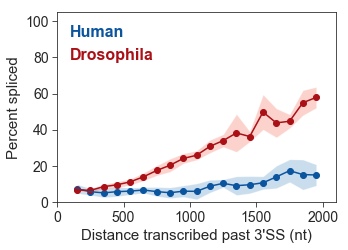

In [5]:
fig, ax = plt.subplots(figsize=(5,3.5))


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 2000      


######### get info for each sample - Human #########
samples=['K562_1','K562_2','K562_3','K562_4','K562_5']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        spliced_count = splicedf_spliced
        unspliced_count = splicedf_unspliced
        plot_list.append([plot_range_high,name,spliced_count,unspliced_count,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','spliced_count','unspliced_count','count','percentSpliced']
human_plot_df = plot_df.copy()
human_N = np.sum(plot_df['count'])

######### get statistics for Human #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for Human #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Blues")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Blues")[4], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Blues")[5])



######### get info for each sample - Drosophila #########
samples=['S2_1','S2_2','S2_3']

plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        spliced_count = splicedf_spliced
        unspliced_count = splicedf_unspliced
        plot_list.append([plot_range_high,name,spliced_count,unspliced_count,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','spliced_count','unspliced_count','count','percentSpliced']
Drosophila_plot_df = plot_df.copy()
Drosophila_N = np.sum(plot_df['count'])

######### get statistics for all samples #########
mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

mean_plot_df = pd.DataFrame(mean)
mean_plot_df.columns = ['range','mean']
mean_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = mean_plot_df['range'].values
y = mean_plot_df['mean'].values
err = mean_plot_df['stdev'].values

ax = plt.plot(x, y, color=sns.color_palette("Reds")[5])
plt.fill_between(x, y-err, y+err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, y, color=sns.color_palette("Reds")[5])


plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)
plt.text(100, 98, 'Human', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Blues")[5])
plt.text(100, 85, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold', color=sns.color_palette("Reds")[5])

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.xlim(0,2100)
plt.ylim(0,105)

plt.savefig('/path/to/Figure_2B_K562_S2_distance_spliced_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [4]:
human_N


72937

In [5]:
Drosophila_N


55774

In [10]:
human_plot_df.to_csv('/path/to/human_distance_transcribed_med_plot_df.txt', sep='\t', header=True, index=False)
Drosophila_plot_df.to_csv('/path/to/drosophila_distance_transcribed_med_plot_df.txt', sep='\t', header=True, index=False)

In [27]:
# FIGURE 2C - splicing of terminal introns when 3' end is at or after poly(A) sites

# upload files from directory

K562_1_termination_df = pd.read_table("/path/to/K562_1_hg38_termination_df.txt",header=0)
K562_2_termination_df = pd.read_table("/path/to/K562_2_hg38_termination_df.txt",header=0)
K562_3_termination_df = pd.read_table("/path/to/K562_3_hg38_termination_df.txt",header=0)
K562_4_termination_df = pd.read_table("/path/to/K562_4_hg38_termination_df.txt",header=0)
K562_5a_termination_df = pd.read_table("/path/to/K562_5a_hg38_termination_df.txt",header=0)
K562_5b_termination_df = pd.read_table("/path/to/K562_5b_hg38_termination_df.txt",header=0)
K562_5_termination_df = pd.concat([K562_5a_termination_df,K562_5b_termination_df],axis=0)

S2_1_termination_df = pd.read_table("/path/to/S2_1_dm6_termination_df.txt",header=0)
S2_2_termination_df = pd.read_table("/path/to/S2_2_dm6_termination_df.txt",header=0)
S2_3_termination_df = pd.read_table("/path/to/S2_3_dm6_termination_df.txt",header=0)


In [3]:
######### set variables for plot #########
polyA_min = -50
polyA_max = 50
post_min = 50      
post_max = 550     


######### get info for each K562 sample #########
plot_list = [] 

samples=['K562_1','K562_2','K562_3','K562_4','K562_5'] 
species='Human'

for k in samples:
    name = '%s' % k # get name of sample
    df = eval('%s_termination_df' % k) # get termination file for this sample
    
    post_range = df[df['polyA_dist'].astype(int).between(post_min, post_max, inclusive=True)] 
    post_spliced = len(post_range[post_range['splice_status']=="YES"])
    post_unspliced = len(post_range[post_range['splice_status']=="NO"])

    if (post_spliced + post_unspliced) > 0: 
        post_percentSpliced = (float(post_spliced) / (float(post_spliced) + float(post_unspliced)))*100
        post_percentUnspliced = (float(post_unspliced) / (float(post_spliced) + float(post_unspliced)))*100
    elif (post_spliced + post_unspliced) == 0: 
        post_percentSpliced = 0.0
        post_percentUnspliced = 0.0
    
    post_percentSpliced = float("{0:.3f}".format(post_percentSpliced))
    post_percentUnspliced = float("{0:.3f}".format(post_percentUnspliced))

    plot_list.append([name, species, 'uncleaved', post_spliced, 'spliced', float(post_percentSpliced)])
    plot_list.append([name, species, 'uncleaved', post_unspliced, 'unspliced', float(post_percentUnspliced)])

    
    polyA_range = df[df['polyA_dist'].astype(int).between(polyA_min, polyA_max, inclusive=True)] 
    polyA_spliced = len(polyA_range[polyA_range['splice_status']=="YES"])
    polyA_unspliced = len(polyA_range[polyA_range['splice_status']=="NO"])
    
    if (polyA_spliced + polyA_unspliced) > 0: 
        polyA_percentSpliced = (float(polyA_spliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
        polyA_percentUnspliced = (float(polyA_unspliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
    elif (polyA_spliced + polyA_unspliced) == 0: 
        polyA_percentSpliced = 0.0
        polyA_percentUnspliced = 0.0
    
    polyA_percentSpliced = float("{0:.3f}".format(polyA_percentSpliced))
    polyA_percentUnspliced = float("{0:.3f}".format(polyA_percentUnspliced))
    
    plot_list.append([name, species, 'cleaved', polyA_spliced, 'spliced', float(polyA_percentSpliced)])
    plot_list.append([name, species, 'cleaved', polyA_unspliced, 'unspliced', float(polyA_percentUnspliced)])

    
K562_plot_df = pd.DataFrame(plot_list)
K562_plot_df.columns = ['name','species', 'position','count','splice_status','percent']



######### get info for each S2 sample #########
plot_list = [] 

samples=['S2_1','S2_2','S2_3'] 
species='Drosophila'

for k in samples:
    name = '%s' % k # get name of sample
    df = eval('%s_termination_df' % k) # get termination file for this sample

    
    post_range = df[df['polyA_dist'].astype(int).between(post_min, post_max, inclusive=True)] 
    post_spliced = len(post_range[post_range['splice_status']=="YES"])
    post_unspliced = len(post_range[post_range['splice_status']=="NO"])

    if (post_spliced + post_unspliced) > 0: 
        post_percentSpliced = (float(post_spliced) / (float(post_spliced) + float(post_unspliced)))*100
        post_percentUnspliced = (float(post_unspliced) / (float(post_spliced) + float(post_unspliced)))*100
    elif (post_spliced + post_unspliced) == 0: 
        post_percentSpliced = 0.0
        post_percentUnspliced = 0.0
    
    post_percentSpliced = float("{0:.3f}".format(post_percentSpliced))
    post_percentUnspliced = float("{0:.3f}".format(post_percentUnspliced))

    plot_list.append([name, species, 'uncleaved', post_spliced, 'spliced', float(post_percentSpliced)])
    plot_list.append([name, species, 'uncleaved', post_unspliced, 'unspliced', float(post_percentUnspliced)])

    
    polyA_range = df[df['polyA_dist'].astype(int).between(polyA_min, polyA_max, inclusive=True)] 
    polyA_spliced = len(polyA_range[polyA_range['splice_status']=="YES"])
    polyA_unspliced = len(polyA_range[polyA_range['splice_status']=="NO"])
    
    if (polyA_spliced + polyA_unspliced) > 0: 
        polyA_percentSpliced = (float(polyA_spliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
        polyA_percentUnspliced = (float(polyA_unspliced) / (float(polyA_spliced) + float(polyA_unspliced)))*100
    elif (polyA_spliced + polyA_unspliced) == 0: 
        polyA_percentSpliced = 0.0
        polyA_percentUnspliced = 0.0
    
    polyA_percentSpliced = float("{0:.3f}".format(polyA_percentSpliced))
    polyA_percentUnspliced = float("{0:.3f}".format(polyA_percentUnspliced))
    
    plot_list.append([name, species, 'cleaved', polyA_spliced, 'spliced', float(polyA_percentSpliced)])
    plot_list.append([name, species, 'cleaved', polyA_unspliced, 'unspliced', float(polyA_percentUnspliced)])

    
S2_plot_df = pd.DataFrame(plot_list)
S2_plot_df.columns = ['name','species', 'position','count','splice_status','percent']


# merge plot dataframes
plot_df = pd.concat([K562_plot_df,S2_plot_df])


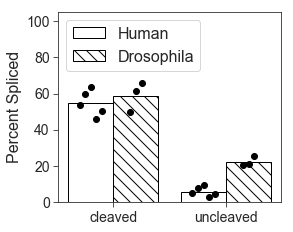

In [29]:

######### plot mean and standard deviation for all samples #########

spliced_plot_df = plot_df[plot_df['splice_status']=='spliced']

fig, ax = plt.subplots(figsize=(4,3.5))

#fill_colors = ['white','white']
#sns.barplot(x='position', y='percent', hue='species', palette=fill_colors, data=spliced_plot_df, ci='sd', errwidth=1.5, capsize=.15)
ax = sns.barplot(x='position', y='percent', hue='species', data=spliced_plot_df, ci=None,
                order=['cleaved','uncleaved'],edgecolor = ['black','black'], fill=False)


# Define some hatches
hatches = ['','','\\\\','\\\\']

# Loop over the bars
for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])



K562_cleaved = spliced_plot_df[(spliced_plot_df['species']=='Human') & (spliced_plot_df['position']=='cleaved')]
ax.plot(-0.3, K562_cleaved.iloc[0]['percent'], "o", color='black', markersize=6)
ax.plot(-0.25, K562_cleaved.iloc[1]['percent'], "o", color='black', markersize=6)
ax.plot(-0.2, K562_cleaved.iloc[2]['percent'], "o", color='black', markersize=6)
ax.plot(-0.15, K562_cleaved.iloc[3]['percent'], "o", color='black', markersize=6)
ax.plot(-0.10, K562_cleaved.iloc[4]['percent'], "o", color='black', markersize=6)

S2_cleaved = spliced_plot_df[(spliced_plot_df['species']=='Drosophila') & (spliced_plot_df['position']=='cleaved')]
ax.plot(0.15, S2_cleaved.iloc[0]['percent'], "o", color='black', markersize=6)
ax.plot(0.2, S2_cleaved.iloc[1]['percent'], "o", color='black', markersize=6)
ax.plot(0.25, S2_cleaved.iloc[2]['percent'], "o", color='black', markersize=6)

K562_uncleaved = spliced_plot_df[(spliced_plot_df['species']=='Human') & (spliced_plot_df['position']=='uncleaved')]
ax.plot(0.7, K562_uncleaved.iloc[0]['percent'], "o", color='black', markersize=6)
ax.plot(0.75, K562_uncleaved.iloc[1]['percent'], "o", color='black', markersize=6)
ax.plot(0.8, K562_uncleaved.iloc[2]['percent'], "o", color='black', markersize=6)
ax.plot(0.85, K562_uncleaved.iloc[3]['percent'], "o", color='black', markersize=6)
ax.plot(0.9, K562_uncleaved.iloc[4]['percent'], "o", color='black', markersize=6)

S2_uncleaved = spliced_plot_df[(spliced_plot_df['species']=='Drosophila') & (spliced_plot_df['position']=='uncleaved')]
ax.plot(1.15, S2_uncleaved.iloc[0]['percent'], "o", color='black', markersize=6)
ax.plot(1.2, S2_uncleaved.iloc[1]['percent'], "o", color='black', markersize=6)
ax.plot(1.25, S2_uncleaved.iloc[2]['percent'], "o", color='black', markersize=6)


plt.ylabel("Percent Spliced", fontsize=16)
plt.xlabel("", fontsize=18, labelpad=10)
#plt.xlabel("Position of the read 3'end", fontsize=18, labelpad=10)
#plt.suptitle("Splicing status of terminal introns", fontsize=20)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)

plt.ylim(0,105)
plt.legend(loc=2, fontsize=16)


plt.savefig('/path/to/Figure_2C_terminal_intron_splicing.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [4]:
print("K562 cleaved: "+str(np.sum(K562_plot_df[(K562_plot_df['position']=='cleaved')]['count'])))
print("K562 uncleaved: "+str(np.sum(K562_plot_df[(K562_plot_df['position']=='uncleaved')]['count'])))
print("S2 cleaved: "+str(np.sum(S2_plot_df[(S2_plot_df['position']=='cleaved')]['count'])))
print("S2 uncleaved: "+str(np.sum(S2_plot_df[(S2_plot_df['position']=='uncleaved')]['count'])))

K562 cleaved: 13913
K562 uncleaved: 4293
S2 cleaved: 9534
S2 uncleaved: 6062


In [8]:
# Statistical test to show that the difference between cleaved and uncleaved is significant

# K562
# get values for Fisher exact test and Chi squared test
cleaved_spliced = np.sum(K562_plot_df[(K562_plot_df['position']=='cleaved') & (K562_plot_df['splice_status']=='spliced')]['count'])
cleaved_unspliced = np.sum(K562_plot_df[(K562_plot_df['position']=='cleaved') & (K562_plot_df['splice_status']=='unspliced')]['count'])
uncleaved_spliced = np.sum(K562_plot_df[(K562_plot_df['position']=='uncleaved') & (K562_plot_df['splice_status']=='spliced')]['count'])
uncleaved_unspliced = np.sum(K562_plot_df[(K562_plot_df['position']=='uncleaved') & (K562_plot_df['splice_status']=='unspliced')]['count'])


oddsratio, pvalue = stats.fisher_exact([[cleaved_spliced, cleaved_unspliced], [uncleaved_spliced, uncleaved_unspliced]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[cleaved_spliced, cleaved_unspliced], [uncleaved_spliced, uncleaved_unspliced]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))




Fisher exact p-value: <2.2e-16
chi-square p-value: <2.2e-16


In [9]:
# S2
# get values for Fisher exact test and Chi squared test
cleaved_spliced = np.sum(S2_plot_df[(S2_plot_df['position']=='cleaved') & (S2_plot_df['splice_status']=='spliced')]['count'])
cleaved_unspliced = np.sum(S2_plot_df[(S2_plot_df['position']=='cleaved') & (S2_plot_df['splice_status']=='unspliced')]['count'])
uncleaved_spliced = np.sum(S2_plot_df[(S2_plot_df['position']=='uncleaved') & (S2_plot_df['splice_status']=='spliced')]['count'])
uncleaved_unspliced = np.sum(S2_plot_df[(S2_plot_df['position']=='uncleaved') & (S2_plot_df['splice_status']=='unspliced')]['count'])


oddsratio, pvalue = stats.fisher_exact([[cleaved_spliced, cleaved_unspliced], [uncleaved_spliced, uncleaved_unspliced]])
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("Fisher exact p-value: <2.2e-16")

if (pvalue>0):
    print("Fisher exact p-value: "+str(pvalue))
      

g, pvalue, dof, expctd = chi2_contingency(np.array([[cleaved_spliced, cleaved_unspliced], [uncleaved_spliced, uncleaved_unspliced]]))
pvalue # the same equation in R shows that this is <2.2e-16

if (pvalue==0):
    print("chi-square p-value: <2.2e-16")

if (pvalue>0):
    print("chi-square p-value: "+str(pvalue))

Fisher exact p-value: <2.2e-16
chi-square p-value: <2.2e-16


/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


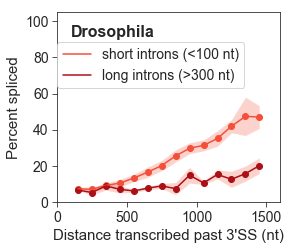

In [11]:
# FIGURE 2D - distance transcribed before splicing plot for different intron lengths

# split drosophila dataframe files into short and long introns
S2_1_short_splice_df = S2_1_splice_df[(S2_1_splice_df['intron_end'].astype(int)-S2_1_splice_df['intron_start'].astype(int)) < 100]
S2_1_med_splice_df = S2_1_splice_df[((S2_1_splice_df['intron_end'].astype(int)-S2_1_splice_df['intron_start'].astype(int)) > 100) & ((S2_1_splice_df['intron_end'].astype(int)-S2_1_splice_df['intron_start'].astype(int)) < 300)]
S2_1_long_splice_df = S2_1_splice_df[(S2_1_splice_df['intron_end'].astype(int)-S2_1_splice_df['intron_start'].astype(int)) > 300]

S2_2_short_splice_df = S2_2_splice_df[(S2_2_splice_df['intron_end'].astype(int)-S2_2_splice_df['intron_start'].astype(int)) < 100]
S2_2_med_splice_df = S2_2_splice_df[((S2_2_splice_df['intron_end'].astype(int)-S2_2_splice_df['intron_start'].astype(int)) > 100) & ((S2_2_splice_df['intron_end'].astype(int)-S2_2_splice_df['intron_start'].astype(int)) < 300)]
S2_2_long_splice_df = S2_2_splice_df[(S2_2_splice_df['intron_end'].astype(int)-S2_2_splice_df['intron_start'].astype(int)) > 300]

S2_3_short_splice_df = S2_3_splice_df[(S2_3_splice_df['intron_end'].astype(int)-S2_3_splice_df['intron_start'].astype(int)) < 100]
S2_3_med_splice_df = S2_3_splice_df[((S2_3_splice_df['intron_end'].astype(int)-S2_3_splice_df['intron_start'].astype(int)) > 100) & ((S2_3_splice_df['intron_end'].astype(int)-S2_3_splice_df['intron_start'].astype(int)) < 300)]
S2_3_long_splice_df = S2_3_splice_df[(S2_3_splice_df['intron_end'].astype(int)-S2_3_splice_df['intron_start'].astype(int)) > 300]


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 1500      

samples=['S2_1','S2_2','S2_3']

######### get info for each sample #########

### short introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_short_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
short_N = np.sum(plot_df['count'])
short_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

short_plot_df = pd.DataFrame(mean)
short_plot_df.columns = ['range','mean']
short_plot_df['stdev'] = stdev


### medium introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_med_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
medium_N = np.sum(plot_df['count'])
medium_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

med_plot_df = pd.DataFrame(mean)
med_plot_df.columns = ['range','mean']
med_plot_df['stdev'] = stdev


### long introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_long_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
long_N = np.sum(plot_df['count'])
long_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

long_plot_df = pd.DataFrame(mean)
long_plot_df.columns = ['range','mean']
long_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = short_plot_df['range'].values
short_y = short_plot_df['mean'].values
short_err = short_plot_df['stdev'].values
med_y = med_plot_df['mean'].values
med_err = med_plot_df['stdev'].values
long_y = long_plot_df['mean'].values
long_err = long_plot_df['stdev'].values

fig, ax = plt.subplots(figsize=(4,3.5))

ax = plt.plot(x, short_y, color=sns.color_palette("Reds")[3], label="short introns (<100 nt)")
plt.fill_between(x, short_y-short_err, short_y+short_err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, short_y, color=sns.color_palette("Reds")[3])

plt.plot(x, long_y, color=sns.color_palette("Reds")[5], label="long introns (>300 nt)")
plt.fill_between(x, long_y-long_err, long_y+long_err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, long_y, color=sns.color_palette("Reds")[5])

plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)
plt.text(100, 98, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(fontsize=14, loc=(0,0.60))

plt.xlim(0,1600)
plt.ylim(0,105)

plt.savefig('/path/to/Figure_2D_S2_distance_spliced_byIntronLength_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [52]:
short_N


37910

In [53]:
long_N


8766

In [13]:
short_df.to_csv('/path/to/drosophila_distance_transcribed_short_introns_med_plot_df.txt', sep='\t', header=True, index=False)
long_df.to_csv('/path/to/drosophila_distance_transcribed_long_introns_med_plot_df.txt', sep='\t', header=True, index=False)

/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


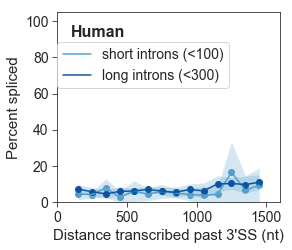

In [14]:
# split human splice dataframe files into short and long introns
short_lim = 100
long_lim = 300

K562_1_short_splice_df = K562_1_splice_df[(K562_1_splice_df['intron_end'].astype(int)-K562_1_splice_df['intron_start'].astype(int)) < short_lim]
K562_1_med_splice_df = K562_1_splice_df[((K562_1_splice_df['intron_end'].astype(int)-K562_1_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_1_splice_df['intron_end'].astype(int)-K562_1_splice_df['intron_start'].astype(int)) < long_lim)]
K562_1_long_splice_df = K562_1_splice_df[(K562_1_splice_df['intron_end'].astype(int)-K562_1_splice_df['intron_start'].astype(int)) > long_lim]

K562_2_short_splice_df = K562_2_splice_df[(K562_2_splice_df['intron_end'].astype(int)-K562_2_splice_df['intron_start'].astype(int)) < short_lim]
K562_2_med_splice_df = K562_2_splice_df[((K562_2_splice_df['intron_end'].astype(int)-K562_2_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_2_splice_df['intron_end'].astype(int)-K562_2_splice_df['intron_start'].astype(int)) < long_lim)]
K562_2_long_splice_df = K562_2_splice_df[(K562_2_splice_df['intron_end'].astype(int)-K562_2_splice_df['intron_start'].astype(int)) > long_lim]

K562_3_short_splice_df = K562_3_splice_df[(K562_3_splice_df['intron_end'].astype(int)-K562_3_splice_df['intron_start'].astype(int)) < short_lim]
K562_3_med_splice_df = K562_3_splice_df[((K562_3_splice_df['intron_end'].astype(int)-K562_3_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_3_splice_df['intron_end'].astype(int)-K562_3_splice_df['intron_start'].astype(int)) < long_lim)]
K562_3_long_splice_df = K562_3_splice_df[(K562_3_splice_df['intron_end'].astype(int)-K562_3_splice_df['intron_start'].astype(int)) > long_lim]

K562_4_short_splice_df = K562_4_splice_df[(K562_4_splice_df['intron_end'].astype(int)-K562_4_splice_df['intron_start'].astype(int)) < short_lim]
K562_4_med_splice_df = K562_4_splice_df[((K562_4_splice_df['intron_end'].astype(int)-K562_4_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_4_splice_df['intron_end'].astype(int)-K562_4_splice_df['intron_start'].astype(int)) < long_lim)]
K562_4_long_splice_df = K562_4_splice_df[(K562_4_splice_df['intron_end'].astype(int)-K562_4_splice_df['intron_start'].astype(int)) > long_lim]

K562_5_short_splice_df = K562_5_splice_df[(K562_5_splice_df['intron_end'].astype(int)-K562_5_splice_df['intron_start'].astype(int)) < short_lim]
K562_5_med_splice_df = K562_5_splice_df[((K562_5_splice_df['intron_end'].astype(int)-K562_5_splice_df['intron_start'].astype(int)) > short_lim) & ((K562_5_splice_df['intron_end'].astype(int)-K562_5_splice_df['intron_start'].astype(int)) < long_lim)]
K562_5_long_splice_df = K562_5_splice_df[(K562_5_splice_df['intron_end'].astype(int)-K562_5_splice_df['intron_start'].astype(int)) > long_lim]


######### set variables for plot #########
window = 100
plot_min = 100
plot_max = 1500      

samples=['K562_1','K562_2','K562_3','K562_4','K562_5']

######### get info for each sample #########

### short introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_short_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
short_N = np.sum(plot_df['count'])
short_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

short_plot_df = pd.DataFrame(mean)
short_plot_df.columns = ['range','mean']
short_plot_df['stdev'] = stdev


### medium introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_med_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
med_N = np.sum(plot_df['count'])
med_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

med_plot_df = pd.DataFrame(mean)
med_plot_df.columns = ['range','mean']
med_plot_df['stdev'] = stdev


### long introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_long_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
long_N = np.sum(plot_df['count'])
long_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

long_plot_df = pd.DataFrame(mean)
long_plot_df.columns = ['range','mean']
long_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = short_plot_df['range'].values
short_y = short_plot_df['mean'].values
short_err = short_plot_df['stdev'].values
med_y = med_plot_df['mean'].values
med_err = med_plot_df['stdev'].values
long_y = long_plot_df['mean'].values
long_err = long_plot_df['stdev'].values

fig, ax = plt.subplots(figsize=(4,3.5))

ax = plt.plot(x, short_y, color=sns.color_palette("Blues")[3], label="short introns (<"+str(short_lim)+")")
plt.fill_between(x, short_y-short_err, short_y+short_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, short_y, color=sns.color_palette("Blues")[3])

plt.plot(x, long_y, color=sns.color_palette("Blues")[5], label="long introns (<"+str(long_lim)+")")
plt.fill_between(x, long_y-long_err, long_y+long_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, long_y, color=sns.color_palette("Blues")[5])

plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
#plt.suptitle("Percent Spliced by Distance Transcribed", fontsize=15, y=0.95)
plt.text(100, 98, 'Human', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500,2000], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(fontsize=14, loc=(0,0.60))

plt.xlim(0,1600)
plt.ylim(0,105)

plt.savefig('/path/to/Figure_2D_K562_distance_spliced_byIntronLength_plot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [15]:
short_N


4802

In [16]:
long_N


52885

In [17]:
short_df.to_csv('/path/to/human_distance_transcribed_short_introns_med_plot_df.txt', sep='\t', header=True, index=False)
long_df.to_csv('/path/to/human_distance_transcribed_long_introns_med_plot_df.txt', sep='\t', header=True, index=False)

In [ ]:
# FIGURE 2E - distance transcribed before splicing plots for alternative vs. constitutive introns

In [18]:
# prepare splicing dataframe for plotting

# get dataframe that includes wanted reads and discards unwanted reads
S2_1_splice_df['gene'] = S2_1_splice_df['gene_name_polyA'].apply(lambda x: '_'.join(x.split('_')[0:2]))
S2_2_splice_df['gene'] = S2_2_splice_df['gene_name_polyA'].apply(lambda x: '_'.join(x.split('_')[0:2]))
S2_3_splice_df['gene'] = S2_3_splice_df['gene_name_polyA'].apply(lambda x: '_'.join(x.split('_')[0:2]))

# trim splicing dataframes to merge with splicing score files
S2_1_splice_trim_df = pd.concat([S2_1_splice_df['read_name'],S2_1_splice_df['chrom'],S2_1_splice_df['intron_start'],S2_1_splice_df['intron_end'],S2_1_splice_df['gene'],S2_1_splice_df['strand'],S2_1_splice_df['dist_from_3SS'],S2_1_splice_df['splice_status']],axis=1)
S2_1_splice_trim_df.columns = ['read_name','chrom','start','end','gene','strand','dist_from_3SS','splice_status']       

S2_2_splice_trim_df = pd.concat([S2_2_splice_df['read_name'],S2_2_splice_df['chrom'],S2_2_splice_df['intron_start'],S2_2_splice_df['intron_end'],S2_2_splice_df['gene'],S2_2_splice_df['strand'],S2_2_splice_df['dist_from_3SS'],S2_2_splice_df['splice_status']],axis=1)
S2_2_splice_trim_df.columns = ['read_name','chrom','start','end','gene','strand','dist_from_3SS','splice_status']       

S2_3_splice_trim_df = pd.concat([S2_3_splice_df['read_name'],S2_3_splice_df['chrom'],S2_3_splice_df['intron_start'],S2_3_splice_df['intron_end'],S2_3_splice_df['gene'],S2_3_splice_df['strand'],S2_3_splice_df['dist_from_3SS'],S2_3_splice_df['splice_status']],axis=1)
S2_3_splice_trim_df.columns = ['read_name','chrom','start','end','gene','strand','dist_from_3SS','splice_status']       

# modify coordinates to match intron dataframe
S2_1_splice_trim_df['start'] = S2_1_splice_trim_df['start'].astype(int)-1
S2_1_splice_trim_df['start'] = S2_1_splice_trim_df['start'].astype(str)
S2_1_splice_trim_df['end'] = S2_1_splice_trim_df['end'].astype(str)

S2_2_splice_trim_df['start'] = S2_2_splice_trim_df['start'].astype(int)-1
S2_2_splice_trim_df['start'] = S2_2_splice_trim_df['start'].astype(str)
S2_2_splice_trim_df['end'] = S2_2_splice_trim_df['end'].astype(str)

S2_3_splice_trim_df['start'] = S2_3_splice_trim_df['start'].astype(int)-1
S2_3_splice_trim_df['start'] = S2_3_splice_trim_df['start'].astype(str)
S2_3_splice_trim_df['end'] = S2_3_splice_trim_df['end'].astype(str)


In [19]:
# read in intron coordinate bed file
dmel_intron_df = pd.read_table('/path/to/annotation_files/dm6_RefSeq_introns_parsed.bed',header=None)
dmel_intron_df.columns = ['chrom','start','end','name','zero','strand']

# convert name to include both gene name and intron number
dmel_intron_df['name'] = dmel_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:4]))

# modify and add columns for easier analysis
dmel_intron_df['chrom'] = dmel_intron_df['chrom'].apply(lambda x: 'chr'+str(x))
dmel_intron_df['gene'] = dmel_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:2]))
dmel_intron_df['feature'] = dmel_intron_df['name'].apply(lambda x: x.split('_')[2])
dmel_intron_df['count'] = dmel_intron_df['name'].apply(lambda x: x.split('_')[3])
dmel_intron_df = dmel_intron_df.drop_duplicates(subset=['name']).reset_index(drop=True)

dmel_intron_df['start'] = dmel_intron_df['start'].astype(str)
dmel_intron_df['end'] = dmel_intron_df['end'].astype(str)


In [20]:
# merge files to add intron name identifier to splicing file
S2_1_splice_df_merge = pd.merge(S2_1_splice_trim_df,dmel_intron_df,on=['chrom','gene','strand','start','end'], how='left')
S2_1_splice_df_merge['gene'] = S2_1_splice_df_merge['name']
S2_1_splice_df_merge = S2_1_splice_df_merge.iloc[:,0:8]
S2_1_splice_df_merge.columns = ['read','chrom','start','end','name','strand','dist_from_3SS','splice_status']

S2_2_splice_df_merge = pd.merge(S2_2_splice_trim_df,dmel_intron_df,on=['chrom','gene','strand','start','end'], how='left')
S2_2_splice_df_merge['gene'] = S2_2_splice_df_merge['name']
S2_2_splice_df_merge = S2_2_splice_df_merge.iloc[:,0:8]
S2_2_splice_df_merge.columns = ['read','chrom','start','end','name','strand','dist_from_3SS','splice_status']

S2_3_splice_df_merge = pd.merge(S2_3_splice_trim_df,dmel_intron_df,on=['chrom','gene','strand','start','end'], how='left')
S2_3_splice_df_merge['gene'] = S2_3_splice_df_merge['name']
S2_3_splice_df_merge = S2_3_splice_df_merge.iloc[:,0:8]
S2_3_splice_df_merge.columns = ['read','chrom','start','end','name','strand','dist_from_3SS','splice_status']


In [21]:
# Read alternative intron annotation file, produced from previous scripts and MISO to classify introns into constitutive
# or alternative based on their neighboring exons
dm6_intron_info_wiAlt = pd.read_table('/path/to/annotation_files/dm6_RefSeq_introns_parsed_wiAltRNAseqMISO.txt', sep='\t')
dm6_intron_info_wiAlt = dm6_intron_info_wiAlt[dm6_intron_info_wiAlt['gene'].str.startswith('NM')]


In [22]:
# Plot splicing kinetics of introns that do or don't neighbor 
# alternatively spliced exons, but using MISO annotations (MXE and SE and A5SS and A3SS) in addition to GTF isoforms

# get information about intron order and merge with splicing file
dm6_intron_alt_df = dm6_intron_info_wiAlt[['name', 'alternative_gtf', 'SE_MISO', 'PSI_SE', 'A5SS_MISO', 'PSI_A5SS',
                                          'A3SS_MISO', 'PSI_A3SS', 'MXE_MISO', 'PSI_MXE']]

S2_1_intron_all_alt_splice_df = pd.merge(S2_1_splice_df_merge, dm6_intron_alt_df, on='name', how='left')
S2_2_intron_all_alt_splice_df = pd.merge(S2_2_splice_df_merge, dm6_intron_alt_df, on='name', how='left')
S2_3_intron_all_alt_splice_df = pd.merge(S2_3_splice_df_merge, dm6_intron_alt_df, on='name', how='left')

# partition splice df files into intron order categories
S2_1_intron_alt_splice_df = S2_1_intron_all_alt_splice_df[(S2_1_intron_all_alt_splice_df['alternative_gtf']=='YES') &
                                                         (((S2_1_intron_all_alt_splice_df['SE_MISO'] == 'YES') & 
                                                           (S2_1_intron_all_alt_splice_df['PSI_SE'] >= 0.8)) |
                                                         ((S2_1_intron_all_alt_splice_df['A5SS_MISO'] == 'YES') & 
                                                          (S2_1_intron_all_alt_splice_df['PSI_A5SS'] >= 0.8)) |
                                                         ((S2_1_intron_all_alt_splice_df['A3SS_MISO'] == 'YES') & 
                                                          (S2_1_intron_all_alt_splice_df['PSI_A3SS'] >= 0.8)) |
                                                         ((S2_1_intron_all_alt_splice_df['MXE_MISO'] == 'YES') & 
                                                          (S2_1_intron_all_alt_splice_df['PSI_MXE'] >= 0.8)))]

S2_1_intron_const_splice_df = S2_1_intron_all_alt_splice_df[(S2_1_intron_all_alt_splice_df['alternative_gtf']=='NO') &
                                                           (S2_1_intron_all_alt_splice_df['SE_MISO'] == 'NO') &
                                                           (S2_1_intron_all_alt_splice_df['A3SS_MISO'] == 'NO') &
                                                           (S2_1_intron_all_alt_splice_df['A5SS_MISO'] == 'NO') &
                                                           (S2_1_intron_all_alt_splice_df['MXE_MISO'] == 'NO')]


S2_2_intron_alt_splice_df = S2_2_intron_all_alt_splice_df[(S2_2_intron_all_alt_splice_df['alternative_gtf']=='YES') &
                                                         (((S2_2_intron_all_alt_splice_df['SE_MISO'] == 'YES') &
                                                          (S2_2_intron_all_alt_splice_df['PSI_SE'] >= 0.8)) |
                                                         ((S2_2_intron_all_alt_splice_df['A5SS_MISO'] == 'YES') &
                                                          (S2_2_intron_all_alt_splice_df['PSI_A5SS'] >= 0.8)) |
                                                         ((S2_2_intron_all_alt_splice_df['A3SS_MISO'] == 'YES') & 
                                                          (S2_2_intron_all_alt_splice_df['PSI_A3SS'] >= 0.8)) |
                                                         ((S2_2_intron_all_alt_splice_df['MXE_MISO'] == 'YES') & 
                                                          (S2_2_intron_all_alt_splice_df['PSI_MXE'] >= 0.8)))]

S2_2_intron_const_splice_df = S2_2_intron_all_alt_splice_df[(S2_2_intron_all_alt_splice_df['alternative_gtf']=='NO') &
                                                           (S2_2_intron_all_alt_splice_df['SE_MISO'] == 'NO') &
                                                           (S2_2_intron_all_alt_splice_df['A3SS_MISO'] == 'NO') &
                                                           (S2_2_intron_all_alt_splice_df['A5SS_MISO'] == 'NO') &
                                                           (S2_2_intron_all_alt_splice_df['MXE_MISO'] == 'NO')]


S2_3_intron_alt_splice_df = S2_3_intron_all_alt_splice_df[(S2_3_intron_all_alt_splice_df['alternative_gtf']=='YES') &
                                                         (((S2_3_intron_all_alt_splice_df['SE_MISO'] == 'YES') &
                                                          (S2_3_intron_all_alt_splice_df['PSI_SE'] >= 0.8)) |
                                                         ((S2_3_intron_all_alt_splice_df['A5SS_MISO'] == 'YES') &
                                                          (S2_3_intron_all_alt_splice_df['PSI_A5SS'] >= 0.8)) |
                                                         ((S2_3_intron_all_alt_splice_df['A3SS_MISO'] == 'YES') & 
                                                          (S2_3_intron_all_alt_splice_df['PSI_A3SS'] >= 0.8)) |
                                                         ((S2_3_intron_all_alt_splice_df['MXE_MISO'] == 'YES') & 
                                                          (S2_3_intron_all_alt_splice_df['PSI_MXE'] >= 0.8)))]

S2_3_intron_const_splice_df = S2_3_intron_all_alt_splice_df[(S2_3_intron_all_alt_splice_df['alternative_gtf']=='NO') &
                                                           (S2_3_intron_all_alt_splice_df['SE_MISO'] == 'NO') &
                                                           (S2_3_intron_all_alt_splice_df['A3SS_MISO'] == 'NO') &
                                                           (S2_3_intron_all_alt_splice_df['A5SS_MISO'] == 'NO') &
                                                           (S2_3_intron_all_alt_splice_df['MXE_MISO'] == 'NO')]

In [8]:
# save datasets to file
S2_1_intron_alt_splice_df.to_csv('path/to/S2_1_intron_alt_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
S2_1_intron_const_splice_df.to_csv('/path/to/S2_1_intron_const_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
S2_2_intron_alt_splice_df.to_csv('/path/to/S2_2_intron_alt_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
S2_2_intron_const_splice_df.to_csv('/path/to/S2_2_intron_const_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
S2_3_intron_alt_splice_df.to_csv('/path/to/S2_3_intron_alt_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
S2_3_intron_const_splice_df.to_csv('/path/to/S2_3_intron_const_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")


/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


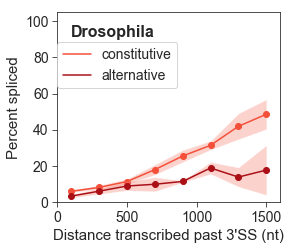

In [23]:
######### set variables for plot #########
window = 200
plot_min = 100
plot_max = 1700      

samples=['S2_1','S2_2','S2_3']

######### get info for each sample #########

### const introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_intron_const_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
const_N = np.sum(plot_df['count'])
const_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

const_plot_df = pd.DataFrame(mean)
const_plot_df.columns = ['range','mean']
const_plot_df['stdev'] = stdev


### alt introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_intron_alt_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
alt_N = np.sum(plot_df['count'])
alt_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

alt_plot_df = pd.DataFrame(mean)
alt_plot_df.columns = ['range','mean']
alt_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = const_plot_df['range'].values
const_y = const_plot_df['mean'].values
const_err = const_plot_df['stdev'].values
alt_y = alt_plot_df['mean'].values
alt_err = alt_plot_df['stdev'].values

fig, ax = plt.subplots(figsize=(4,3.5))

ax = plt.plot(x, const_y, color=sns.color_palette("Reds")[3], label="constitutive")
plt.fill_between(x, const_y-const_err, const_y+const_err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, const_y, color=sns.color_palette("Reds")[3])

plt.plot(x, alt_y, color=sns.color_palette("Reds")[5], label="alternative")
plt.fill_between(x, alt_y-alt_err, alt_y+alt_err, facecolor=sns.color_palette("Reds")[3], interpolate=True, alpha=0.25)
plt.scatter(x, alt_y, color=sns.color_palette("Reds")[5])

plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
plt.text(100, 98, 'Drosophila', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,500,1000,1500], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(fontsize=14, loc=(0,0.60))

plt.xlim(0,1600)
plt.ylim(0,105)

plt.savefig('/path/to/Figure_2E_S2_distance_spliced_byAltSplicing_plot.pdf',
           format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
const_N

32511

In [25]:
alt_N

3221

In [26]:
const_df.to_csv('/path/to/drosophila_distance_transcribed_const_introns_med_plot_df.txt', sep='\t', header=True, index=False)
alt_df.to_csv('/path/to/drosophila_distance_transcribed_alt_introns_med_plot_df.txt', sep='\t', header=True, index=False)

In [27]:
# prepare splicing dataframe for plotting

# get dataframe that includes wanted reads and discards unwanted reads
K562_1_splice_df['gene'] = K562_1_splice_df['gene_name_polyA'].apply(lambda x: '_'.join(x.split('_')[0:2]))
K562_2_splice_df['gene'] = K562_2_splice_df['gene_name_polyA'].apply(lambda x: '_'.join(x.split('_')[0:2]))
K562_3_splice_df['gene'] = K562_3_splice_df['gene_name_polyA'].apply(lambda x: '_'.join(x.split('_')[0:2]))
K562_4_splice_df['gene'] = K562_4_splice_df['gene_name_polyA'].apply(lambda x: '_'.join(x.split('_')[0:2]))
K562_5_splice_df['gene'] = K562_5_splice_df['gene_name_polyA'].apply(lambda x: '_'.join(x.split('_')[0:2]))

# trim splicing dataframes to merge with splicing score files
K562_1_splice_trim_df = pd.concat([K562_1_splice_df['read_name'],K562_1_splice_df['chrom'],K562_1_splice_df['intron_start'],K562_1_splice_df['intron_end'],K562_1_splice_df['gene'],K562_1_splice_df['strand'],K562_1_splice_df['dist_from_3SS'],K562_1_splice_df['splice_status']],axis=1)
K562_1_splice_trim_df.columns = ['read_name','chrom','start','end','gene','strand','dist_from_3SS','splice_status']       

K562_2_splice_trim_df = pd.concat([K562_2_splice_df['read_name'],K562_2_splice_df['chrom'],K562_2_splice_df['intron_start'],K562_2_splice_df['intron_end'],K562_2_splice_df['gene'],K562_2_splice_df['strand'],K562_2_splice_df['dist_from_3SS'],K562_2_splice_df['splice_status']],axis=1)
K562_2_splice_trim_df.columns = ['read_name','chrom','start','end','gene','strand','dist_from_3SS','splice_status']       

K562_3_splice_trim_df = pd.concat([K562_3_splice_df['read_name'],K562_3_splice_df['chrom'],K562_3_splice_df['intron_start'],K562_3_splice_df['intron_end'],K562_3_splice_df['gene'],K562_3_splice_df['strand'],K562_3_splice_df['dist_from_3SS'],K562_3_splice_df['splice_status']],axis=1)
K562_3_splice_trim_df.columns = ['read_name','chrom','start','end','gene','strand','dist_from_3SS','splice_status']       

K562_4_splice_trim_df = pd.concat([K562_4_splice_df['read_name'],K562_4_splice_df['chrom'],K562_4_splice_df['intron_start'],K562_4_splice_df['intron_end'],K562_4_splice_df['gene'],K562_4_splice_df['strand'],K562_4_splice_df['dist_from_3SS'],K562_4_splice_df['splice_status']],axis=1)
K562_4_splice_trim_df.columns = ['read_name','chrom','start','end','gene','strand','dist_from_3SS','splice_status']       

K562_5_splice_trim_df = pd.concat([K562_5_splice_df['read_name'],K562_5_splice_df['chrom'],K562_5_splice_df['intron_start'],K562_5_splice_df['intron_end'],K562_5_splice_df['gene'],K562_5_splice_df['strand'],K562_5_splice_df['dist_from_3SS'],K562_5_splice_df['splice_status']],axis=1)
K562_5_splice_trim_df.columns = ['read_name','chrom','start','end','gene','strand','dist_from_3SS','splice_status']       

# modify coordinates to match intron dataframe
K562_1_splice_trim_df['start'] = K562_1_splice_trim_df['start'].astype(int)-1
K562_1_splice_trim_df['start'] = K562_1_splice_trim_df['start'].astype(str)
K562_1_splice_trim_df['end'] = K562_1_splice_trim_df['end'].astype(str)

K562_2_splice_trim_df['start'] = K562_2_splice_trim_df['start'].astype(int)-1
K562_2_splice_trim_df['start'] = K562_2_splice_trim_df['start'].astype(str)
K562_2_splice_trim_df['end'] = K562_2_splice_trim_df['end'].astype(str)

K562_3_splice_trim_df['start'] = K562_3_splice_trim_df['start'].astype(int)-1
K562_3_splice_trim_df['start'] = K562_3_splice_trim_df['start'].astype(str)
K562_3_splice_trim_df['end'] = K562_3_splice_trim_df['end'].astype(str)

K562_4_splice_trim_df['start'] = K562_4_splice_trim_df['start'].astype(int)-1
K562_4_splice_trim_df['start'] = K562_4_splice_trim_df['start'].astype(str)
K562_4_splice_trim_df['end'] = K562_4_splice_trim_df['end'].astype(str)

K562_5_splice_trim_df['start'] = K562_5_splice_trim_df['start'].astype(int)-1
K562_5_splice_trim_df['start'] = K562_5_splice_trim_df['start'].astype(str)
K562_5_splice_trim_df['end'] = K562_5_splice_trim_df['end'].astype(str)



In [28]:
# read in intron coordinate bed file
hg_intron_df = pd.read_table('/path/to/annotation_files/NCBI_RefSeq_hg38_introns_parsed.bed',header=None,low_memory=False)
hg_intron_df.columns = ['chrom','start','end','name','zero','strand']

# convert name to include both gene name and intron number
hg_intron_df['name'] = hg_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:4]))

# modify and add columns for easier analysis
#hg_intron_df['chrom'] = hg_intron_df['chrom'].apply(lambda x: 'chr'+str(x))
hg_intron_df['gene'] = hg_intron_df['name'].apply(lambda x: '_'.join(x.split('_')[0:2]))
hg_intron_df['feature'] = hg_intron_df['name'].apply(lambda x: x.split('_')[2])
hg_intron_df['count'] = hg_intron_df['name'].apply(lambda x: x.split('_')[3])
hg_intron_df = hg_intron_df.drop_duplicates(subset=['name']).reset_index(drop=True)

hg_intron_df['start'] = hg_intron_df['start'].astype(str)
hg_intron_df['end'] = hg_intron_df['end'].astype(str)


In [29]:
# merge files to add intron name identifier to splicing file
K562_1_splice_df_merge = pd.merge(K562_1_splice_trim_df,hg_intron_df,on=['chrom','gene','strand','start','end'], how='left')
K562_1_splice_df_merge['gene'] = K562_1_splice_df_merge['name']
K562_1_splice_df_merge = K562_1_splice_df_merge.iloc[:,0:8]
K562_1_splice_df_merge.columns = ['read','chrom','start','end','name','strand','dist_from_3SS','splice_status']

K562_2_splice_df_merge = pd.merge(K562_2_splice_trim_df,hg_intron_df,on=['chrom','gene','strand','start','end'], how='left')
K562_2_splice_df_merge['gene'] = K562_2_splice_df_merge['name']
K562_2_splice_df_merge = K562_2_splice_df_merge.iloc[:,0:8]
K562_2_splice_df_merge.columns = ['read','chrom','start','end','name','strand','dist_from_3SS','splice_status']

K562_3_splice_df_merge = pd.merge(K562_3_splice_trim_df,hg_intron_df,on=['chrom','gene','strand','start','end'], how='left')
K562_3_splice_df_merge['gene'] = K562_3_splice_df_merge['name']
K562_3_splice_df_merge = K562_3_splice_df_merge.iloc[:,0:8]
K562_3_splice_df_merge.columns = ['read','chrom','start','end','name','strand','dist_from_3SS','splice_status']

K562_4_splice_df_merge = pd.merge(K562_4_splice_trim_df,hg_intron_df,on=['chrom','gene','strand','start','end'], how='left')
K562_4_splice_df_merge['gene'] = K562_4_splice_df_merge['name']
K562_4_splice_df_merge = K562_4_splice_df_merge.iloc[:,0:8]
K562_4_splice_df_merge.columns = ['read','chrom','start','end','name','strand','dist_from_3SS','splice_status']

K562_5_splice_df_merge = pd.merge(K562_5_splice_trim_df,hg_intron_df,on=['chrom','gene','strand','start','end'], how='left')
K562_5_splice_df_merge['gene'] = K562_5_splice_df_merge['name']
K562_5_splice_df_merge = K562_5_splice_df_merge.iloc[:,0:8]
K562_5_splice_df_merge.columns = ['read','chrom','start','end','name','strand','dist_from_3SS','splice_status']



In [30]:
hg38_intron_info_wiAlt = pd.read_table('/path/to/hg38_RefSeq_introns_parsed_wiAltRNAseqMISO.v2.txt')
hg38_intron_info_wiAlt = hg38_intron_info_wiAlt[hg38_intron_info_wiAlt['gene'].str.startswith('NM')]


In [31]:
# Plot splicing kinetics of introns that do or don't neighbor 
# alternatively spliced exons, but using MISO annotations (MXE and SE and A5SS and A3SS) in addition to GTF isoforms

# get information about intron order and merge with splicing file
hg38_intron_alt_df = hg38_intron_info_wiAlt[['name', 'alternative_gtf', 'SE_MISO', 'PSI_SE', 'A5SS_MISO', 'PSI_A5SS',
                                          'A3SS_MISO', 'PSI_A3SS', 'MXE_MISO', 'PSI_MXE']]

K562_1_intron_all_alt_splice_df = pd.merge(K562_1_splice_df_merge, hg38_intron_alt_df, on='name', how='left')
K562_2_intron_all_alt_splice_df = pd.merge(K562_2_splice_df_merge, hg38_intron_alt_df, on='name', how='left')
K562_3_intron_all_alt_splice_df = pd.merge(K562_3_splice_df_merge, hg38_intron_alt_df, on='name', how='left')
K562_4_intron_all_alt_splice_df = pd.merge(K562_4_splice_df_merge, hg38_intron_alt_df, on='name', how='left')
K562_5_intron_all_alt_splice_df = pd.merge(K562_5_splice_df_merge, hg38_intron_alt_df, on='name', how='left')

# partition splice df files into intron order categories
K562_1_intron_alt_splice_df = K562_1_intron_all_alt_splice_df[((K562_1_intron_all_alt_splice_df['SE_MISO'] == 'YES') & 
                                                           (K562_1_intron_all_alt_splice_df['PSI_SE'] >= 0.8)) |
                                                         ((K562_1_intron_all_alt_splice_df['A5SS_MISO'] == 'YES') & 
                                                          (K562_1_intron_all_alt_splice_df['PSI_A5SS'] >= 0.8)) |
                                                         ((K562_1_intron_all_alt_splice_df['A3SS_MISO'] == 'YES') & 
                                                          (K562_1_intron_all_alt_splice_df['PSI_A3SS'] >= 0.8)) |
                                                         ((K562_1_intron_all_alt_splice_df['MXE_MISO'] == 'YES') & 
                                                          (K562_1_intron_all_alt_splice_df['PSI_MXE'] >= 0.8))]

K562_1_intron_const_splice_df = K562_1_intron_all_alt_splice_df[(K562_1_intron_all_alt_splice_df['SE_MISO'] == 'NO') &
                                                           (K562_1_intron_all_alt_splice_df['A5SS_MISO'] == 'NO') &
                                                           (K562_1_intron_all_alt_splice_df['A3SS_MISO'] == 'NO') &
                                                           (K562_1_intron_all_alt_splice_df['MXE_MISO'] == 'NO')]


K562_2_intron_alt_splice_df = K562_2_intron_all_alt_splice_df[((K562_2_intron_all_alt_splice_df['SE_MISO'] == 'YES') & 
                                                           (K562_2_intron_all_alt_splice_df['PSI_SE'] >= 0.8)) |
                                                         ((K562_2_intron_all_alt_splice_df['A5SS_MISO'] == 'YES') & 
                                                          (K562_2_intron_all_alt_splice_df['PSI_A5SS'] >= 0.8)) |
                                                         ((K562_2_intron_all_alt_splice_df['A3SS_MISO'] == 'YES') & 
                                                          (K562_2_intron_all_alt_splice_df['PSI_A3SS'] >= 0.8)) |
                                                         ((K562_2_intron_all_alt_splice_df['MXE_MISO'] == 'YES') & 
                                                          (K562_2_intron_all_alt_splice_df['PSI_MXE'] >= 0.8))]

K562_2_intron_const_splice_df = K562_2_intron_all_alt_splice_df[(K562_2_intron_all_alt_splice_df['SE_MISO'] == 'NO') &
                                                           (K562_2_intron_all_alt_splice_df['A5SS_MISO'] == 'NO') &
                                                           (K562_2_intron_all_alt_splice_df['A3SS_MISO'] == 'NO') &
                                                           (K562_2_intron_all_alt_splice_df['MXE_MISO'] == 'NO')]


K562_3_intron_alt_splice_df = K562_3_intron_all_alt_splice_df[((K562_3_intron_all_alt_splice_df['SE_MISO'] == 'YES') & 
                                                           (K562_3_intron_all_alt_splice_df['PSI_SE'] >= 0.8)) |
                                                         ((K562_3_intron_all_alt_splice_df['A5SS_MISO'] == 'YES') & 
                                                          (K562_3_intron_all_alt_splice_df['PSI_A5SS'] >= 0.8)) |
                                                         ((K562_3_intron_all_alt_splice_df['A3SS_MISO'] == 'YES') & 
                                                          (K562_3_intron_all_alt_splice_df['PSI_A3SS'] >= 0.8)) |
                                                         ((K562_3_intron_all_alt_splice_df['MXE_MISO'] == 'YES') & 
                                                          (K562_3_intron_all_alt_splice_df['PSI_MXE'] >= 0.8))]

K562_3_intron_const_splice_df = K562_3_intron_all_alt_splice_df[(K562_3_intron_all_alt_splice_df['SE_MISO'] == 'NO') &
                                                           (K562_3_intron_all_alt_splice_df['A5SS_MISO'] == 'NO') &
                                                           (K562_3_intron_all_alt_splice_df['A3SS_MISO'] == 'NO') &
                                                           (K562_3_intron_all_alt_splice_df['MXE_MISO'] == 'NO')]


K562_4_intron_alt_splice_df = K562_4_intron_all_alt_splice_df[((K562_4_intron_all_alt_splice_df['SE_MISO'] == 'YES') & 
                                                           (K562_4_intron_all_alt_splice_df['PSI_SE'] >= 0.8)) |
                                                         ((K562_4_intron_all_alt_splice_df['A5SS_MISO'] == 'YES') & 
                                                          (K562_4_intron_all_alt_splice_df['PSI_A5SS'] >= 0.8)) |
                                                         ((K562_4_intron_all_alt_splice_df['A3SS_MISO'] == 'YES') & 
                                                          (K562_4_intron_all_alt_splice_df['PSI_A3SS'] >= 0.8)) |
                                                         ((K562_4_intron_all_alt_splice_df['MXE_MISO'] == 'YES') & 
                                                          (K562_4_intron_all_alt_splice_df['PSI_MXE'] >= 0.8))]

K562_4_intron_const_splice_df = K562_4_intron_all_alt_splice_df[(K562_4_intron_all_alt_splice_df['SE_MISO'] == 'NO') &
                                                           (K562_4_intron_all_alt_splice_df['A5SS_MISO'] == 'NO') &
                                                           (K562_4_intron_all_alt_splice_df['A3SS_MISO'] == 'NO') &
                                                           (K562_4_intron_all_alt_splice_df['MXE_MISO'] == 'NO')]


K562_5_intron_alt_splice_df = K562_5_intron_all_alt_splice_df[((K562_5_intron_all_alt_splice_df['SE_MISO'] == 'YES') & 
                                                           (K562_5_intron_all_alt_splice_df['PSI_SE'] >= 0.8)) |
                                                         ((K562_5_intron_all_alt_splice_df['A5SS_MISO'] == 'YES') & 
                                                          (K562_5_intron_all_alt_splice_df['PSI_A5SS'] >= 0.8)) |
                                                         ((K562_5_intron_all_alt_splice_df['A3SS_MISO'] == 'YES') & 
                                                          (K562_5_intron_all_alt_splice_df['PSI_A3SS'] >= 0.8)) |
                                                         ((K562_5_intron_all_alt_splice_df['MXE_MISO'] == 'YES') & 
                                                          (K562_5_intron_all_alt_splice_df['PSI_MXE'] >= 0.8))]

K562_5_intron_const_splice_df = K562_5_intron_all_alt_splice_df[(K562_5_intron_all_alt_splice_df['SE_MISO'] == 'NO') &
                                                           (K562_5_intron_all_alt_splice_df['A5SS_MISO'] == 'NO') &
                                                           (K562_5_intron_all_alt_splice_df['A3SS_MISO'] == 'NO') &
                                                           (K562_5_intron_all_alt_splice_df['MXE_MISO'] == 'NO')]


In [15]:
# save datasets to file
K562_1_intron_alt_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_1_intron_alt_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_1_intron_const_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_1_intron_const_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_2_intron_alt_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_2_intron_alt_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_2_intron_const_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_2_intron_const_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_3_intron_alt_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_3_intron_alt_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_3_intron_const_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_3_intron_const_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_4_intron_alt_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_4_intron_alt_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_4_intron_const_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_4_intron_const_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_5_intron_alt_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_5_intron_alt_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")
K562_5_intron_const_splice_df.to_csv('/Users/K562_drexler/Dropbox/Harvard/ChurchmanLab/NanoporePaper/Revisions/Datasets/nanoCOP/alt_splicing/K562_5_intron_const_splice_df.txt', sep='\t', index=False, header=True, na_rep="NaN")

K562_intron_alt_splice_df = pd.concat([K562_1_intron_alt_splice_df,K562_2_intron_alt_splice_df,K562_3_intron_alt_splice_df,K562_4_intron_alt_splice_df,K562_5_intron_alt_splice_df])
K562_intron_const_splice_df = pd.concat([K562_1_intron_const_splice_df,K562_2_intron_const_splice_df,K562_3_intron_const_splice_df,K562_4_intron_const_splice_df,K562_5_intron_const_splice_df])



/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/karinechoquet/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


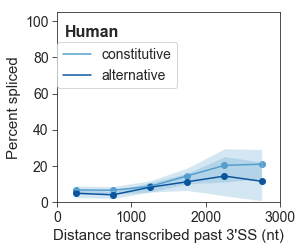

In [32]:
######### set variables for plot #########
window = 500
plot_min = 100
plot_max = 3100      

samples=['K562_1','K562_2','K562_3','K562_4','K562_5']


######### get info for each sample #########

### short introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_intron_const_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
const_N = np.sum(plot_df['count'])
const_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

const_plot_df = pd.DataFrame(mean)
const_plot_df.columns = ['range','mean']
const_plot_df['stdev'] = stdev


### long introns
plot_list = [] 
for k in samples:
    name = '%s' % k # get name of sample
    splice_df = eval('%s_intron_alt_splice_df' % k) # get splicing file for this sample
    
    for i in range(int(plot_min/window)-1,int(plot_max/window)):
        plot_range_low = i*window
        plot_range_high = (i+1)*window
        splicedf_range = splice_df[splice_df['dist_from_3SS'].astype(int).between(plot_range_low, plot_range_high, inclusive=True)] 
        splicedf_spliced = len(splicedf_range[splicedf_range['splice_status']=="YES"])
        splicedf_unspliced = len(splicedf_range[splicedf_range['splice_status']=="NO"])
        splicedf_undetermined = len(splicedf_range[splicedf_range['splice_status']=="UNDETERMINED"])
        if (splicedf_spliced + splicedf_unspliced) > 0: 
            splicedf_percentSpliced = (float(splicedf_spliced) / (float(splicedf_spliced) + float(splicedf_unspliced)))*100
        elif (splicedf_spliced + splicedf_unspliced) == 0: 
            splicedf_percentSpliced = 0.0

        splicedf_percentSpliced = float("{0:.3f}".format(splicedf_percentSpliced))
        count = splicedf_spliced + splicedf_unspliced
        plot_list.append([plot_range_high,name,count,float(splicedf_percentSpliced)])

plot_df = pd.DataFrame(plot_list)
plot_df.columns = ['range','name','count','percentSpliced']
alt_N = np.sum(plot_df['count'])
alt_df = plot_df.copy()

mean = []
stdev = []
for i in range(int(plot_min/window),int(plot_max/window)):
    plot_range_low = i*window
    plot_range_high = (i+1)*window
    plot_range_middle = (plot_range_low + plot_range_high) / 2
    mean.append([int(plot_range_middle), np.mean(plot_df[plot_df['range']==plot_range_high]['percentSpliced'])])
    stdev.append(np.std(plot_df[plot_df['range']==plot_range_high]['percentSpliced']))    

alt_plot_df = pd.DataFrame(mean)
alt_plot_df.columns = ['range','mean']
alt_plot_df['stdev'] = stdev

######### plot mean and standard deviation for all samples #########

x = const_plot_df['range'].values
const_y = const_plot_df['mean'].values
const_err = const_plot_df['stdev'].values
alt_y = alt_plot_df['mean'].values
alt_err = alt_plot_df['stdev'].values

fig, ax = plt.subplots(figsize=(4,3.5))

ax = plt.plot(x, const_y, color=sns.color_palette("Blues")[3], label="constitutive")
plt.fill_between(x, const_y-const_err, const_y+const_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, const_y, color=sns.color_palette("Blues")[3])

plt.plot(x, alt_y, color=sns.color_palette("Blues")[5], label="alternative")
plt.fill_between(x, alt_y-alt_err, alt_y+alt_err, facecolor=sns.color_palette("Blues")[3], interpolate=True, alpha=0.25)
plt.scatter(x, alt_y, color=sns.color_palette("Blues")[5])

plt.ylabel("Percent spliced", fontsize=15)
plt.xlabel("Distance transcribed past 3'SS (nt)", fontsize=15)
plt.text(100, 98, 'Human', horizontalalignment='left', verticalalignment='top', fontsize=16, weight='bold')

plt.xticks([0,1000,2000,3000], fontsize=14)
plt.yticks([0,20,40,60,80,100], fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(axis='both', which='both', labelsize=14, direction='out', left="on", bottom="on", length=5)
plt.legend(fontsize=14, loc=(0,0.60))

plt.xlim(0,3000)
plt.ylim(0,105)

plt.savefig('/path/to/Figure_2E_K562_distance_spliced_byAltSplicing_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [33]:
const_N

60080

In [34]:
alt_N

11236

In [35]:
const_df.to_csv('/path/to/human_distance_transcribed_const_introns_med_plot_df.txt', sep='\t', header=True, index=False)
alt_df.to_csv('/path/to/human_distance_transcribed_alt_introns_med_plot_df.txt', sep='\t', header=True, index=False)